In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('body', 'body')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.01,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': False
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

            test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)


            # build model
            model = get_model(args)
            model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
            model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)

            model.eval()


            # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
            success_counts = [0 for _ in range(10)]
            failure_counts = [0 for _ in range(10)]

            # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
            success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
            failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]

            # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
            accuracies = [0 for _ in range(10)]


            # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
            with torch.no_grad():
                for images, labels in test_dataloader:
                    if args.gpu != -1:
                        images, labels = images.to(args.device), labels.to(args.device)

                    outputs = model(images)
                    softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                    predicted_labels = torch.argmax(softmax_probs, dim=1)

                    for i in range(len(labels)):
                        label = labels[i].item()
                        predicted_label = predicted_labels[i].item()
                        prob_vector = softmax_probs[i]

                        if predicted_label == label:
                            # 예측 성공한 경우
                            success_counts[label] += 1
                            success_prob_sums[label] += prob_vector
                            accuracies[label] += 1
                        else:
                            # 예측 실패한 경우
                            failure_counts[label] += 1
                            failure_prob_sums[label] += prob_vector


        # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
        success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
        failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
        classwise_accuracy=[]

        # 결과 출력
        for i in range(10):
            print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
            classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
            print("Success Probability Vector:")
            print(success_prob_vectors[i])

        # 결과 출력
        for i in range(10):
            print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")

            print("Failure Probability Vector:")
            print(failure_prob_vectors[i])
        print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 84.70%
Success Probability Vector:
tensor([9.7137e-01, 9.7630e-04, 1.0139e-02, 8.4845e-04, 2.5700e-03, 4.0114e-04,
        1.2415e-03, 1.1014e-03, 7.1479e-03, 4.2017e-03], device='cuda:0')
Class 2 - Accuracy: 89.90%
Success Probability Vector:
tensor([2.3245e-03, 9.8146e-01, 4.3816e-04, 7.9463e-04, 1.2988e-04, 1.0167e-03,
        8.6944e-04, 8.1917e-05, 3.7702e-03, 9.1156e-03], device='cuda:0')
Class 3 - Accuracy: 69.70%
Success Probability Vector:
tensor([7.3064e-03, 4.1613e-04, 9.5324e-01, 7.4565e-03, 9.2685e-03, 9.7640e-03,
        7.6174e-03, 2.9024e-03, 1.0036e-03, 1.0210e-03], device='cuda:0')
Class 4 - Accuracy: 61.80%
Success Probability Vector:
tensor([0.0041, 0.0020, 0.0114, 0.9159, 0.0093, 0.0396, 0.0100, 0.0051, 0.0011,
        0.0015], device='cuda:0')
Class 5 - Accuracy: 75.60%
Success Probability Vector:
tensor([2.4980e-03, 3.9360e-04, 1.2541e-02, 8.4991e-03, 9.5126e-01, 5.923

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 66.5562973022461, Variance = 406.1982116699219, Min = 26.263498306274414, Max = 149.63218688964844
Class 1 (Failed): Mean = 50.37858200073242, Variance = 161.11984252929688, Min = 24.14434051513672, Max = 97.73873138427734
Class 2 (Successful): Mean = 93.30232238769531, Variance = 1537.1341552734375, Min = 25.305082321166992, Max = 345.8424072265625
Class 2 (Failed): Mean = 57.17267608642578, Variance = 294.53375244140625, Min = 29.18220329284668, Max = 105.09326934814453
Class 3 (Successful): Mean = 66.62039184570312, Variance = 508.73321533203125, Min = 27.38634490966797, Max = 184.19297790527344
Class 3 (Failed): Mean = 50.29301452636719, Variance = 116.33100891113281, Min = 29.774002075195312, Max = 86.05754852294922
Class 4 (Successful): Mean = 53.95570373535156, Variance = 213.74490356445312, Min = 21.161781311035156, Max = 136.3013153076172
Class 4 (Failed): Mean = 50.6665153503418, Variance = 165.99069213867188, Min = 21.468883514404297, Max = 120.2

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('body', 'body')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.01,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': False
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

            dict_save_path = 'dict_users_10.pkl'
            with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                dict_users_train, dict_users_test = pickle.load(handle)


            # build model
            net_glob = get_model(args)
            net_glob.train()


            net_local_list = []
            for user_ix in range(args.num_users):
                net_local_list.append(copy.deepcopy(net_glob))

            criterion = nn.CrossEntropyLoss()

            before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
            after_acc_results = []

            for user, net_local in enumerate(net_local_list):
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                before_acc_results.append(acc_test)

            print(before_acc_results)

            print ("Before min/max/mean/std of accuracy")
            print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))

                    
                    


Files already downloaded and verified
Files already downloaded and verified
[80.0, 73.0, 85.0, 76.0, 82.0, 78.0, 86.0, 78.0, 79.0, 83.0, 80.0, 75.0, 77.0, 80.0, 73.0, 76.0, 81.0, 83.0, 86.0, 74.0, 78.0, 71.0, 77.0, 83.0, 86.0, 80.0, 81.0, 80.0, 73.0, 82.0, 80.0, 81.0, 86.0, 73.0, 84.0, 84.0, 77.0, 78.0, 80.0, 74.0, 80.0, 79.0, 81.0, 83.0, 81.0, 78.0, 83.0, 79.0, 84.0, 76.0, 77.0, 77.0, 76.0, 80.0, 81.0, 77.0, 78.0, 82.0, 83.0, 81.0, 77.0, 83.0, 72.0, 76.0, 77.0, 82.0, 77.0, 78.0, 81.0, 75.0, 82.0, 77.0, 76.0, 85.0, 78.0, 79.0, 79.0, 79.0, 76.0, 83.0, 81.0, 77.0, 77.0, 74.0, 79.0, 72.0, 78.0, 73.0, 77.0, 84.0, 86.0, 84.0, 82.0, 77.0, 78.0, 75.0, 77.0, 79.0, 79.0, 87.0]
Before min/max/mean/std of accuracy
71.0 87.0 79.17 3.64


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {0: 49, 1: 54, 2: 56, 3: 40, 4: 54, 5: 47, 6: 54, 7: 53, 8: 47, 9: 46}, 1: {0: 46, 1: 52, 2: 45, 3: 42, 4: 59, 5: 45, 6: 53, 7: 64, 8: 41, 9: 53}, 2: {0: 47, 1: 52, 2: 56, 3: 41, 4: 53, 5: 43, 6: 38, 7: 52, 8: 55, 9: 63}, 3: {0: 49, 1: 44, 2: 53, 3: 52, 4: 56, 5: 56, 6: 45, 7: 47, 8: 55, 9: 43}, 4: {0: 50, 1: 54, 2: 49, 3: 54, 4: 45, 5: 53, 6: 55, 7: 47, 8: 53, 9: 40}, 5: {0: 47, 1: 44, 2: 38, 3: 52, 4: 54, 5: 63, 6: 54, 7: 53, 8: 49, 9: 46}, 6: {0: 41, 1: 53, 2: 54, 3: 47, 4: 55, 5: 44, 6: 53, 7: 58, 8: 51, 9: 44}, 7: {0: 58, 1: 44, 2: 49, 3: 42, 4: 63, 5: 45, 6: 60, 7: 43, 8: 55, 9: 41}, 8: {0: 40, 1: 44, 2: 60, 3: 48, 4: 49, 5: 37, 6: 60, 7: 52, 8: 63, 9: 47}, 9: {0: 53, 1: 45, 2: 49, 3: 65, 4: 58, 5: 42, 6: 55, 7: 43, 8: 38, 9: 52}, 10: {0: 54, 1: 54, 2: 46, 3: 42, 4: 41, 5: 53, 6: 54, 7: 54, 8: 50, 9: 52}, 11: {0: 46, 1: 51, 2: 50, 3: 47, 4: 48, 5: 55, 6: 55, 7: 43, 8: 58, 9: 47}, 12: {0: 58, 1: 49, 2: 45, 3: 54, 4: 59, 5:

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {0: 4, 1: 12, 2: 18, 3: 10, 4: 7, 5: 11, 6: 13, 7: 7, 8: 12, 9: 6}, 1: {0: 7, 1: 12, 2: 12, 3: 6, 4: 8, 5: 11, 6: 8, 7: 16, 8: 12, 9: 8}, 2: {0: 10, 1: 11, 2: 8, 3: 13, 4: 6, 5: 10, 6: 12, 7: 8, 8: 9, 9: 13}, 3: {0: 12, 1: 12, 2: 9, 3: 5, 4: 8, 5: 13, 6: 12, 7: 7, 8: 8, 9: 14}, 4: {0: 6, 1: 10, 2: 7, 3: 8, 4: 10, 5: 12, 6: 9, 7: 15, 8: 11, 9: 12}, 5: {0: 9, 1: 13, 2: 9, 3: 9, 4: 14, 5: 8, 6: 18, 7: 6, 8: 7, 9: 7}, 6: {0: 11, 1: 12, 2: 11, 3: 8, 4: 6, 5: 10, 6: 10, 7: 9, 8: 9, 9: 14}, 7: {0: 11, 1: 11, 2: 6, 3: 13, 4: 9, 5: 12, 6: 8, 7: 8, 8: 11, 9: 11}, 8: {0: 12, 1: 9, 2: 10, 3: 7, 4: 16, 5: 13, 6: 8, 7: 7, 8: 8, 9: 10}, 9: {0: 15, 1: 7, 2: 10, 3: 10, 4: 18, 5: 10, 6: 6, 7: 3, 8: 11, 9: 10}, 10: {0: 10, 1: 12, 2: 8, 3: 11, 4: 9, 5: 9, 6: 8, 7: 14, 8: 9, 9: 10}, 11: {0: 11, 1: 11, 2: 13, 3: 11, 4: 6, 5: 12, 6: 10, 7: 13, 8: 9, 9: 4}, 12: {0: 6, 1: 10, 2: 11, 3: 12, 4: 8, 5: 10, 6: 9, 7: 12, 8: 12, 9: 10}, 13: {0: 20, 1: 7, 2: 11

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([-0.0319,  0.0383,  0.0208, -0.0020, -0.0234,  0.0149,  0.0372, -0.0413,
        -0.0151,  0.0232], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([0.3233, 0.3360, 0.3247, 0.3356, 0.3469, 0.3316, 0.3183, 0.3414, 0.3340,
        0.3452], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000e+00, -7.6741e-02,  3.0262e-02,  1.5851e-02,  1.0705e-01,
         -2.0421e-02, -3.1438e-02,  3.2524e-02, -2.0170e-02,  4.7581e-02],
        [-7.6741e-02,  1.0000e+00, -1.4284e-02, -3.0394e-02,  2.9169e-02,
          6.5581e-02, -2.9996e-02, -1.2811e-02, -2.1647e-02, -1.4465e-02],
        [ 3.0262e-02, -1.4284e-02,  1.0000e+00,  4.6461e-02,  5.4966e-03,
          1.8842e-02,  1.0452e-03,  1.1918e-02,  4.4771e-03, -1.5096e-02],
        [ 1.5851e-02, -3.0394e-02,  4.6461e-02,  1.0000e+00, -7.6463e-03,
         -1.2543e-02,  2.240

Weight norm of each class part of classifier
tensor([0.5686, 0.5797, 0.5698, 0.5793, 0.5889, 0.5758, 0.5642, 0.5843, 0.5779,
        0.5875], device='cuda:0', grad_fn=<SqrtBackward0>)


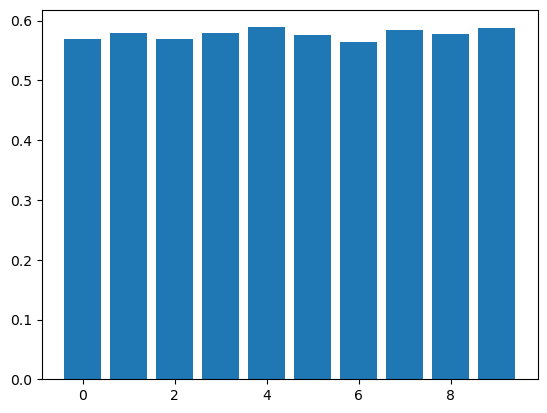

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

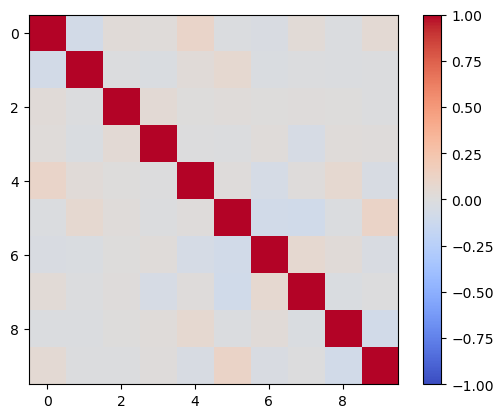

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.92732996, 1: 0.95889026, 2: 0.90526086, 3: 0.90498716, 4: 0.9266148, 5: 0.9268092, 6: 0.93769985, 7: 0.93913174, 8: 0.94782376, 9: 0.94528}
-------------------VAR-------------------
{0: 0.0056592845, 1: 0.004661804, 2: 0.0060502817, 3: 0.005180709, 4: 0.004949927, 5: 0.004920414, 6: 0.004227326, 7: 0.0056158225, 8: 0.0063181934, 9: 0.006276065}


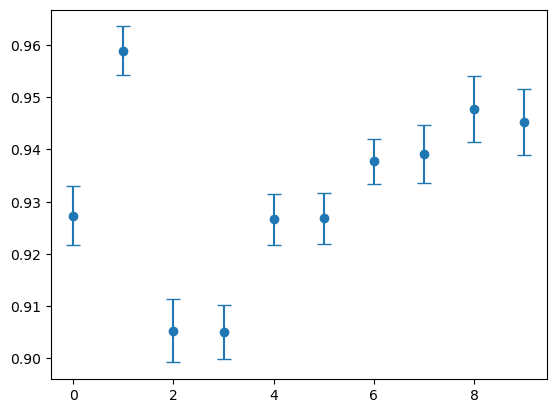

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('body', 'body')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.01,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': False
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

            dict_save_path = 'dict_users_10.pkl'
            with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                dict_users_train, dict_users_test = pickle.load(handle)


            # build model
            net_glob = get_model(args)
            net_glob.train()


            net_local_list = []
            for user_ix in range(args.num_users):
                net_local_list.append(copy.deepcopy(net_glob))

            criterion = nn.CrossEntropyLoss()

            before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
            after_acc_results = []

            for user, net_local in enumerate(net_local_list):
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                before_acc_results.append(acc_test)

            net_local_list[0].eval()

            label= [i for i in range(num_classes)]                    


            ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
            class_sums = {i: None for i in label}
            class_counts = {i: None for i in label}



            with torch.no_grad():
                for idx, (images, labels) in enumerate(ldr_test):
                    images, labels = images.to(args.device), labels.to(args.device)
                    features = net_local_list[0].extract_features(images)

                    for i in range(len(label)):
                        class_mask = labels == label[i]  

                        if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                            class_features = features[class_mask]
                            class_sum = class_features.sum(dim=0)
                            count=class_features.shape[0]

                            if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                class_sums[label[i]]=class_sum
                                class_counts[label[i]]=count
                            else:
                                class_sums[label[i]]+=class_sum
                                class_counts[label[i]]+=count

            #Get the class-wise feature centroid                    
            class_mean_dict={}
            for key, value in class_sums.items():
                if key in class_counts:
                    class_mean_dict[key] = value / class_counts[key]

            print(class_mean_dict)
            #Get a Inner product of each class's centroid vector

            sorted_keys=sorted(class_mean_dict)
            print(sorted_keys)

            class_mean_lst=[]


            for key in sorted_keys:
                class_mean_lst.append(class_mean_dict[key])

            class_mean_lst=torch.stack(class_mean_lst)


            print(class_mean_lst.shape)
            print(class_mean_lst.transpose(0,1).shape)

            #Get the each centroid vector's norm
            print("-------------Norm of each centroid vectors --------------")
            print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


            #Get the cosine similarity result between eacn centroid vectors


            normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
            print("-------------Cosine similarity of Each Centroid vectors--------------")
            print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())





Files already downloaded and verified
Files already downloaded and verified
{0: tensor([5.2619e+00, 1.4175e+00, 4.3577e+00, 1.2497e+00, 1.0286e+00, 0.0000e+00,
        3.7775e+00, 3.8958e+00, 5.4627e+00, 6.0208e-02, 4.8771e-02, 3.3216e-01,
        3.6339e+00, 3.4192e+00, 1.1787e-02, 2.2169e+00, 3.4216e+00, 4.2736e+00,
        9.0257e-01, 1.6274e+00, 1.6768e-03, 4.6206e+00, 7.7542e-01, 4.2122e+00,
        1.3664e+00, 2.2237e+00, 3.3080e+00, 5.1245e+00, 3.3825e+00, 2.1731e+00,
        6.6225e-02, 2.4294e-01, 7.8707e+00, 1.7784e+00, 2.8429e-01, 0.0000e+00,
        4.3327e-06, 2.8873e-02, 5.1950e-01, 3.2999e+00, 9.1528e+00, 0.0000e+00,
        0.0000e+00, 8.1361e-01, 6.5152e-01, 3.2168e+00, 2.9999e+00, 1.0253e+00,
        8.3831e-01, 2.0688e+00, 4.8143e-02, 2.2426e+00, 3.6383e+00, 1.1780e+00,
        3.1231e+00, 7.7048e-04, 1.4059e+00, 3.5519e+00, 3.0834e+00, 2.1585e+00,
        7.9260e+00, 1.4644e+00, 0.0000e+00, 1.4937e-01, 5.5602e-01, 5.4084e-01,
        1.5434e+00, 2.4754e-01, 1.2271e-

# Cosine Similarity of Centroid Vectors

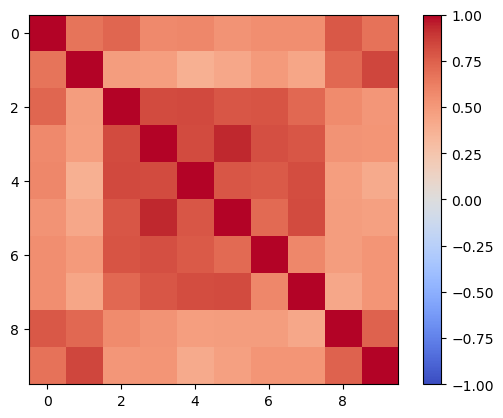

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[1.0000001  0.6642852  0.72105926 0.5742945  0.5809418  0.5259953
  0.5486574  0.5546142  0.77882177 0.67707264]
 [0.6642852  1.0000001  0.48159516 0.47105917 0.38243997 0.4256999
  0.4954327  0.4328437  0.7119092  0.8424516 ]
 [0.72105926 0.48159516 1.0000001  0.82624483 0.8322612  0.788792
  0.79553765 0.71412694 0.56777555 0.51229304]
 [0.5742945  0.47105917 0.82624483 1.         0.8244021  0.9358993
  0.8082422  0.7827099  0.5277704  0.5156608 ]
 [0.5809418  0.38243997 0.8322612  0.8244021  1.         0.78377414
  0.76680183 0.81544507 0.4725233  0.41071916]
 [0.5259953  0.4256999  0.788792   0.9358993  0.78377414 1.
  0.7051401  0.8227936  0.48029548 0.4650035 ]
 [0.5486574  0.4954327  0.79553765 0.8082422  0.76680183 0.7051401
  1.         0.58482915 0.48175994 0.5208005 ]
 [0.5546142  0.4328437  0.71412694 0.7827099  0.81544507 0.8227936
  0.58482915 1.0000001  0.42968288 0.52230394]
 [0.77882177 0.7119092  0.56777555 0.5277704  0.4725233  0.48029548
  0

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.4151, 0.4177, 0.3658, 0.3156, 0.3687, 0.3544, 0.4016, 0.3852, 0.4141,
        0.4096], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.4151, 0.4177, 0.3658, 0.3156, 0.3687, 0.3544, 0.4016, 0.3852, 0.4141,
        0.4096], device='cuda:0', grad_fn=<DiagonalBackward0>)


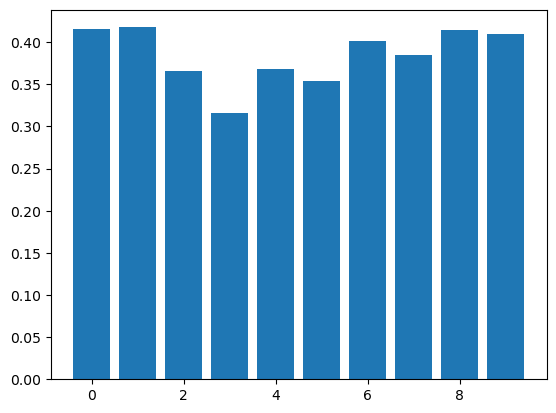

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()

# Singular Value Analysis

Files already downloaded and verified
Files already downloaded and verified
['3.070', '2.462', '2.407', '2.312', '2.236', '2.206', '2.072', '2.040', '1.899', '1.806', '1.111', '1.097', '1.085', '1.083', '1.078', '1.075', '1.069', '1.058', '1.056', '1.053', '1.050', '1.041', '1.035', '1.029', '1.028', '1.022', '1.014', '1.011', '1.007', '1.006', '1.005', '1.000', '0.993', '0.989', '0.983', '0.978', '0.977', '0.973', '0.972', '0.967', '0.965', '0.957', '0.955', '0.952', '0.950', '0.944', '0.942', '0.941', '0.932', '0.931', '0.929', '0.927', '0.923', '0.922', '0.920', '0.916', '0.908', '0.906', '0.904', '0.901', '0.897', '0.894', '0.893', '0.892', '0.888', '0.886', '0.884', '0.882', '0.877', '0.875', '0.871', '0.868', '0.862', '0.861', '0.858', '0.857', '0.854', '0.852', '0.851', '0.845', '0.841', '0.840', '0.838', '0.836', '0.833', '0.830', '0.828', '0.825', '0.824', '0.818', '0.815', '0.813', '0.812', '0.808', '0.806', '0.803', '0.802', '0.798', '0.797', '0.796', '0.793', '0.788', '0.78

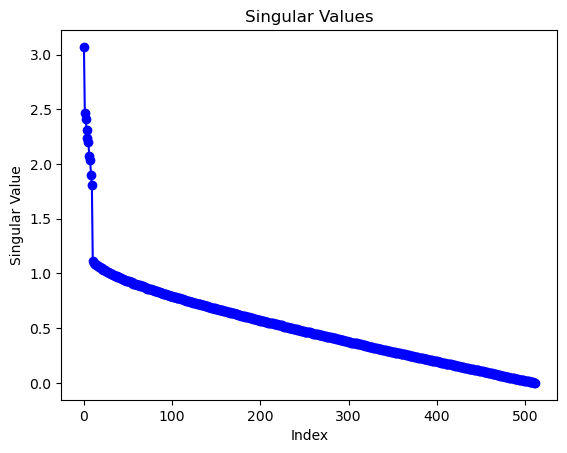

In [18]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('body', 'body')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.01,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': False
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
            test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)


            # build model
            model = get_model(args)
            model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
            model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)

            model.eval()

            info_param = [p for name, p in model.named_parameters() if 'fc.2.weight' in name]

            # Compute the singular value decomposition (SVD)
            _, s, _ = torch.svd(info_param[0])

            # Sort the singular values in descending order and store them in a list
            sorted_s = sorted(s.tolist(), reverse=True)

            print(["{:.3f}".format(num) for num in sorted_s])

            # Create a list of indices for the singular values
            indices = list(range(len(sorted_s)))

            # Plot the singular values with their indices
            plt.plot(indices, sorted_s, marker='o', linestyle='-', color='b')
            plt.xlabel('Index')
            plt.ylabel('Singular Value')
            plt.title('Singular Values')

            # Set x-axis ticks to display only integer values
#                 plt.xticks(indices)

            plt.show()

